In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from numpy import random
import pandas as pd
import numpy as np
import sys
import seaborn as sns
# import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')

sns.set_palette('Dark2')
plt.rcParams['figure.figsize'] = (8,6)
%matplotlib inline

# custom file
import wine_config # wine_config.get_config() is a dict
config = wine_config.get_config()

In [14]:
path = config['path']

In [15]:
wines = pd.read_csv(
    path +'Google Drive/Data Science/WineData/wineData_1_44000.csv', 
    encoding='utf-8')
wines = wines.drop(['level_0', 'index'], axis=1)

In [16]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31972 entries, 0 to 31971
Data columns (total 23 columns):
@context       31972 non-null object
@id            31972 non-null object
@type          31972 non-null object
alc            29432 non-null float64
category       31235 non-null object
closure        22665 non-null object
description    27687 non-null object
foodnote       14345 non-null object
image          31972 non-null object
name           31972 non-null object
origin         27051 non-null object
pH             28053 non-null float64
pack           28043 non-null object
rs             28424 non-null float64
size           9698 non-null object
sku            31972 non-null int64
style          18686 non-null object
ta             27871 non-null float64
type           28870 non-null object
variety        30838 non-null object
winemaker      30603 non-null object
wood           13804 non-null object
year           29288 non-null float64
dtypes: float64(5), int64(1), object(

In [17]:
wines['year'] = wines.name.apply(lambda x: x.strip()[-4:])
wines['year'] = pd.to_numeric(wines['year'], errors='coerce')
wines[['name','year']].describe()

,year
count,29288.000000
mean,2007.422494
std,5.591047
min,1930.000000
25%,2003.000000
50%,2008.000000
75%,2012.000000
max,2018.000000


The smallest year doesn't look right, so this can be investigated and fixed if the problem is small

In [18]:
print(min(wines.year), max(wines.year))
print(wines.name[wines.year<1900])

(1930.0, 2018.0)
Series([], Name: name, dtype: object)


There are only a few wrong names, so it is easy to clean manually, with an assumption that 200 should be 2000

In [19]:
wines.loc[2820, 'name'] = 'Vredenheim 2008'
wines.loc[3798, 'name'] = 'Helderberg Chenin Blanc 2000'
wines.loc[9804, 'name'] = 'Backsberg Chenin Blanc 2000'
wines.loc[24813, 'name'] = 'Teddy Hall Dr Jan Cats Chenin Blanc Reserve 2011'

wines['year'] = wines.name.apply(lambda x: x.strip()[-4:])
wines['year'] = pd.to_numeric(wines['year'], errors='coerce')
wines[['name','year']].describe()

,year
count,29288.000000
mean,2007.422494
std,5.591047
min,1930.000000
25%,2003.000000
50%,2008.000000
75%,2012.000000
max,2018.000000


# Looking at the data visually

Resources: 
- https://www.wosa.co.za/The-Industry/Varieties-and-Styles/Wine-Styles/
- https://winefolly.com/

## Year

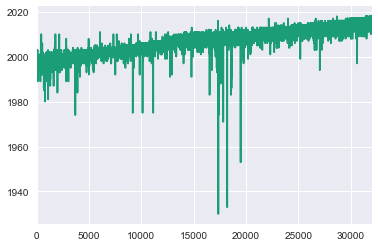

In [20]:
wines.year.dropna().plot()

As expected, the average wines listed on the website get newer for later url integers in the scraped pages. It is interesting that there are occasionally very old wines added to the listing

## Type

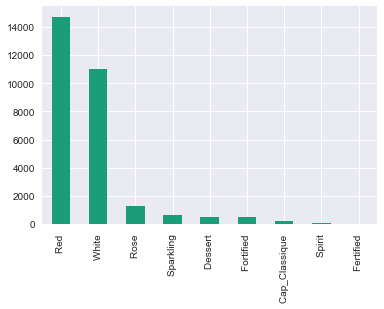

In [21]:
wines.type.value_counts().plot(kind='bar')

We seem to have a 'fertified' type now which is clearly a typo.

In [22]:
wines[wines.type == 'Fertified'] = 'Fortified'

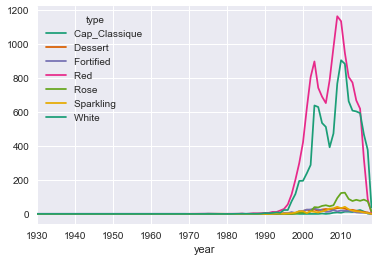

In [23]:
year_type = wines[['year','type']].dropna()
year_type = pd.crosstab(year_type.year, year_type.type)
year_type.plot()

## Variety

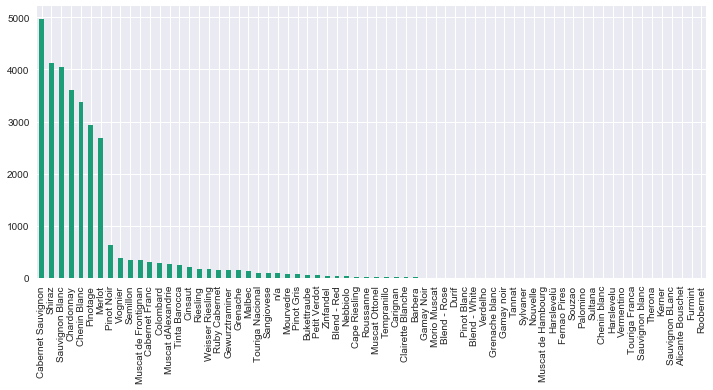

In [24]:
plt.figure(figsize=(12,5))
wines.variety.value_counts().plot(kind='bar')

/Users/lauren/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1998.0, right=1998.0
  'left=%s, right=%s') % (left, right))
/Users/lauren/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1995.0, right=1995.0
  'left=%s, right=%s') % (left, right))
/Users/lauren/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1999.0, right=1999.0
  'left=%s, right=%s') % (left, right))
/Users/lauren/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2001.

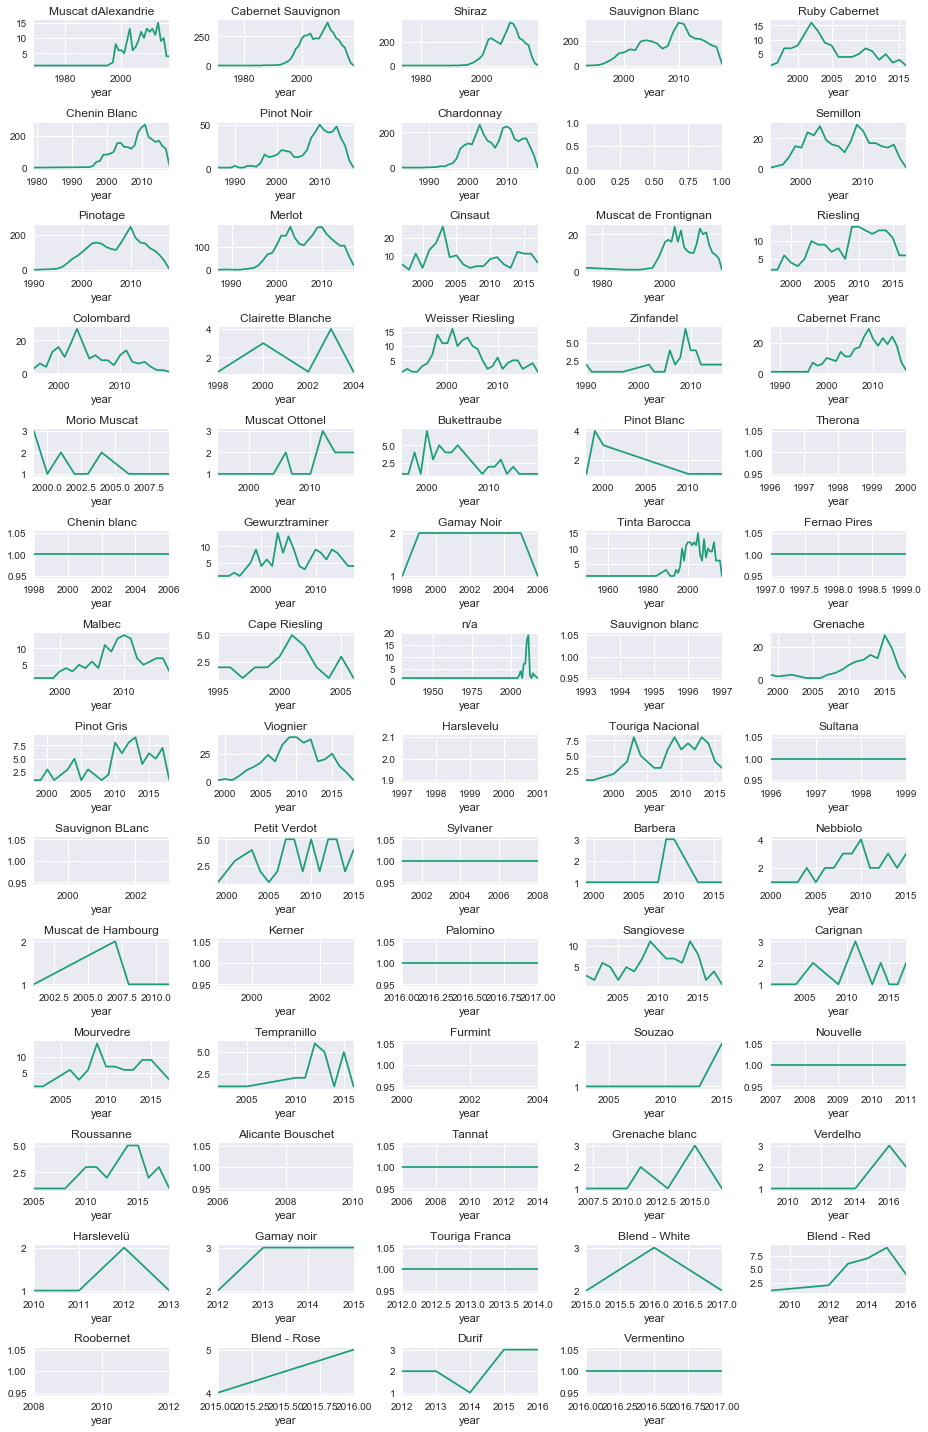

In [25]:
varieties = wines.variety.unique()
plt.figure(figsize=(13,20))
for v in range(len(varieties)):
    ax = plt.subplot((len(varieties)+1)//5, 5 ,v+1)
    wines_sub = wines[wines.variety == varieties[v]]
    year_variety = wines_sub[['year','variety']].dropna()
    year_variety = pd.crosstab(wines_sub.year,wines_sub.variety)
    try:
        year_variety.plot(ax=ax, legend=False)
        plt.title(varieties[v])
    except TypeError:
        pass
plt.tight_layout()

## Wine Content

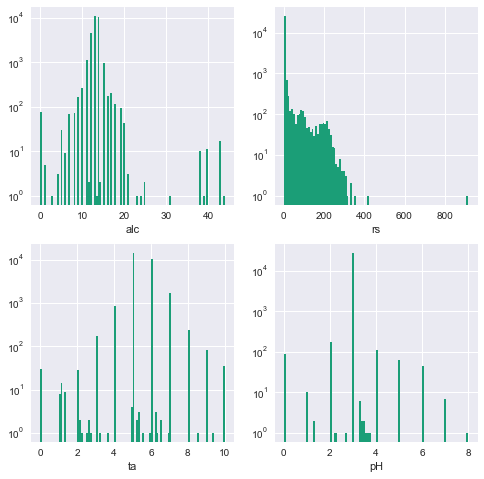

In [26]:
metrics = ['alc','rs','ta','pH']
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(wines[metrics[i]].dropna(), log=True, bins = 100)
    plt.xlabel(metrics[i])


It appears that there are a lot of outliers, some of which are likely to be incorrect. There are no negative values, so we can look only at the values that are too high.

### Alcohol

Wine alcohol is measured in percentage, which cannot be over 100%

In [27]:
wines[wines.alc>100].head()

,@context,@id,@type,alc,category,closure,description,foodnote,image,name,...,rs,size,sku,style,ta,type,variety,winemaker,wood,year


In [28]:
print 'Before cleaning:', min(wines.alc), max(wines.alc)
while len(wines[wines.alc>100])>0:
    wines.alc[wines.alc>100] /= 10
    
print 'After cleaning:', min(wines.alc), max(wines.alc)

Before cleaning: 0.0 44.0
After cleaning: 0.0 44.0


### Residual sugar

RS is the residual sugar, which is measured in grams/L. According to https://winefolly.com/review/sugar-in-wine-chart/, the range of values should be from 0 to 220.

In [29]:
print 'Before cleaning:', min(wines.rs.dropna()), max(wines.rs.dropna())
print 'Number of wines with sugar >220 g/L', len(wines[wines.rs>220])
wines[wines.rs>220].head()

Before cleaning: 0.0 917.0
Number of wines with sugar >220 g/L 139


,@context,@id,@type,alc,category,closure,description,foodnote,image,name,...,rs,size,sku,style,ta,type,variety,winemaker,wood,year
83,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=107,Product,16.0,Muscat de Frontignan,NaN,This is an opulent sweet fortified wine of unf...,NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Rooiberg Red Muscadel 2001,...,226.0,NaN,107,NaN,3.0,Red,Muscat de Frontignan,Andre van Dyk,NaN,2001.0
165,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=213,Product,17.0,Muscat dAlexandrie,NaN,This elegant ruby sweet wine is made from heal...,NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Boland Red Muscadel 1997,...,269.0,NaN,213,NaN,3.0,Fortified,Muscat dAlexandrie,Charl du Plessis,NaN,1997.0
232,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=321,Product,16.0,Muscat de Frontignan,NaN,The result is a rich wine with a fine bouquet ...,NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Weltevrede Cape Muscat 2001,...,238.0,NaN,321,NaN,5.0,Fortified,Muscat de Frontignan,Philip Jonker,NaN,2001.0
644,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=869,Product,14.0,Chardonnay,Cork,This full-bodied Chardonnay epitomizes old-wor...,NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Buitenverwachting Chardonnay 1998,...,301.0,NaN,869,NaN,6.0,White,Chardonnay,Herman Kirschbaum,NaN,1998.0
899,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=1181,Product,17.0,Muscat de Frontignan,NaN,"A ruby-coloured, full-sweet desert-wine with m...",NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Robertson Muscadel (Sweet Red Wine) 1998,...,246.0,NaN,1181,NaN,5.0,NaN,Muscat de Frontignan,The Robertson Team,NaN,1998.0


Muscat is a dessert wine, and according to http://www.wineguy.co.nz/index.php/81-all-about-wine/239-residual-sugar, it is sensible that it has high sugar, so perhaps 250 is a better limit. It is not normal to have a chardonnay with such high sugar though  

In [30]:

print 'Number of wines with sugar >250 g/L', len(wines[(wines.rs>250)&(wines.category.str.contains('Muscat')==False)])
print(wines[(wines.rs>250)&(wines.category.str.contains('Muscat')==False)].category.unique())
print(wines[(wines.rs>250)&(wines.category.str.contains('Muscat')==False)].type.value_counts())
wines[(wines.rs>250)&(wines.category.str.contains('Muscat')==False)].head()

Number of wines with sugar >250 g/L 23
[u'Chardonnay' u'Pinotage' u'Shiraz' u'Chenin Blanc' u'Cabernet Sauvignon'
 u'n/a' u'Zinfandel' u'Sauvignon Blanc']
Dessert       14
Red            4
Fortified      3
Spirit         1
White          1
Name: type, dtype: int64


,@context,@id,@type,alc,category,closure,description,foodnote,image,name,...,rs,size,sku,style,ta,type,variety,winemaker,wood,year
644,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=869,Product,14.0,Chardonnay,Cork,This full-bodied Chardonnay epitomizes old-wor...,NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Buitenverwachting Chardonnay 1998,...,301.0,NaN,869,NaN,6.0,White,Chardonnay,Herman Kirschbaum,NaN,1998.0
2018,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=2566,Product,17.0,Pinotage,NaN,"Full-sweet dessert wine. Deep, rich red colour...",NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Slanghoek Red Jerepigo 2003,...,257.0,NaN,2566,NaN,3.0,Fortified,Pinotage,Pieter Carstens & Team,NaN,2003.0
2782,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=3579,Product,18.0,Shiraz,NaN,"Deep, dark ruby, with a youthful purplish tint...",NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Alto Estate Port 1997,...,917.0,NaN,3579,Dry,5.0,Fortified,Shiraz,Schalk van der Westhuizen,wooded,1997.0
9847,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=13232,Product,18.0,Pinotage,NaN,Medium red colour. Ripe red berries on the nos...,NaN,http://images.wine.co.za/GetWineImage.ashx?Ima...,Slanghoek Private Selection Red Jerepigo 2005,...,254.0,NaN,13232,Sweet,6.0,Fortified,Pinotage,Pieter Carstens & Team,NaN,2005.0
12420,http://schema.org,https://wine.co.za/wine/wine.aspx?WINEID=18775,Product,10.0,Chenin Blanc,Cork,The wine is lovely and honeyed on the nose and...,Pair with ripe cheeses or enjoy on its own. \r\n,http://images.wine.co.za/GetWineImage.ashx?Ima...,Lammershoek Straw Wine 2008,...,307.0,NaN,18775,Sticky,8.0,Dessert,Chenin Blanc,Albert Ahrens,wooded,2008.0


Most of these are labelled dessert wine, so the high sugar makes sense. The white and red wines seem out of place, but the information online is not specific and I'm no expert, so I will leave this as is.

### Titratable acidity
TA is the titratable acidity, or concentration of acids in the wine, which is measured in g/L or %. The previous plots imply that our measurements are in g/L. According to http://www.grapestompers.com/measure_acidity.aspx, it is unlikely we should find acidities over 10

In [31]:
print 'Before cleaning:', min(wines.ta.dropna()), max(wines.ta.dropna())
print 'Number of wines with acidity >100 g/L', len(wines[wines.ta>10])
wines[wines.ta>10].head()

Before cleaning: 0.0 10.0
Number of wines with acidity >100 g/L 0


,@context,@id,@type,alc,category,closure,description,foodnote,image,name,...,rs,size,sku,style,ta,type,variety,winemaker,wood,year


Accroding to https://winefolly.com/review/understanding-wine-tech-sheets/, a wine above TA=10 is sour, so we have to assume that some error has been made in recording these values and the low number of values above 10 confirms this theory. 

In [32]:
while len(wines[wines.ta>10])>0:
    wines.ta[wines.ta>10] /= 10
print 'After cleaning:', min(wines.ta.dropna()), max(wines.ta.dropna())

After cleaning: 0.0 10.0


### pH

pH is the measure of the acidity in taste. According to https://winefolly.com/review/understanding-acidity-in-wine/, the values generally fall between 2.5 and 4.5. Our plots show that there are definitely some inaccurate masurements

In [33]:
print 'Before cleaning:', min(wines.pH.dropna()), max(wines.pH.dropna())
print 'Number of wines with pH <3 or pH>4 g/L', len(wines[(wines.pH<2.5)|(wines.pH>4.5)])
wines[(wines.pH<2.5)|(wines.pH>4.5)][['description', 'category', 'type', 'name','@id' ,'pH', 'ta']].head()

Before cleaning: 0.0 8.0
Number of wines with pH <3 or pH>4 g/L 396


,description,category,type,name,@id,pH,ta
158,NaN,Muscat Ottonel,Dessert,Blaauwklippen Muscat Ottonel 1995,https://wine.co.za/wine/wine.aspx?WINEID=204,2.0,6.0
548,Garnet red colour. The nose shows pepper and f...,Shiraz,NaN,Simonsig Shiraz 1997,https://wine.co.za/wine/wine.aspx?WINEID=750,6.0,6.0
636,A blend of 55% Shiraz and 45% Cabernet Sauvign...,Shiraz,Red,Hazendal Shiraz Cabernet Sauvignon 1998,https://wine.co.za/wine/wine.aspx?WINEID=861,5.0,3.0
755,This full-bodied dry wine with its pleasant li...,Chardonnay,White,Boland Chardonnay 1997,https://wine.co.za/wine/wine.aspx?WINEID=1006,2.0,5.0
763,A refreshingly sweet wine made from selected g...,Sauvignon Blanc,White,Boland Vin Doux 1997,https://wine.co.za/wine/wine.aspx?WINEID=1015,2.0,7.0


Frim the header, we do not see the values that are far too high yet, but we do see many wines that fall outside expected values. Since these are old wines, it is hard to check the values so I will change the threshold to >10

In [34]:
print 'Number of wines with pH <3 or pH>4 g/L', len(wines[wines.pH>10])
wines[wines.pH>10][['description', 'category', 'type', 'name','@id' ,'pH']].head()

Number of wines with pH <3 or pH>4 g/L 0


,description,category,type,name,@id,pH


After inspecting these numbers, it is again the most likely situation that typos have been made in the insertion of the numbers. It is, however, iteresting to look at the Hamilton Russell Vineyards Chardonnay 2011 wine where I did some research and none of the bottles have pH information so it is unclear where the website obtained such a number.

31972 24948


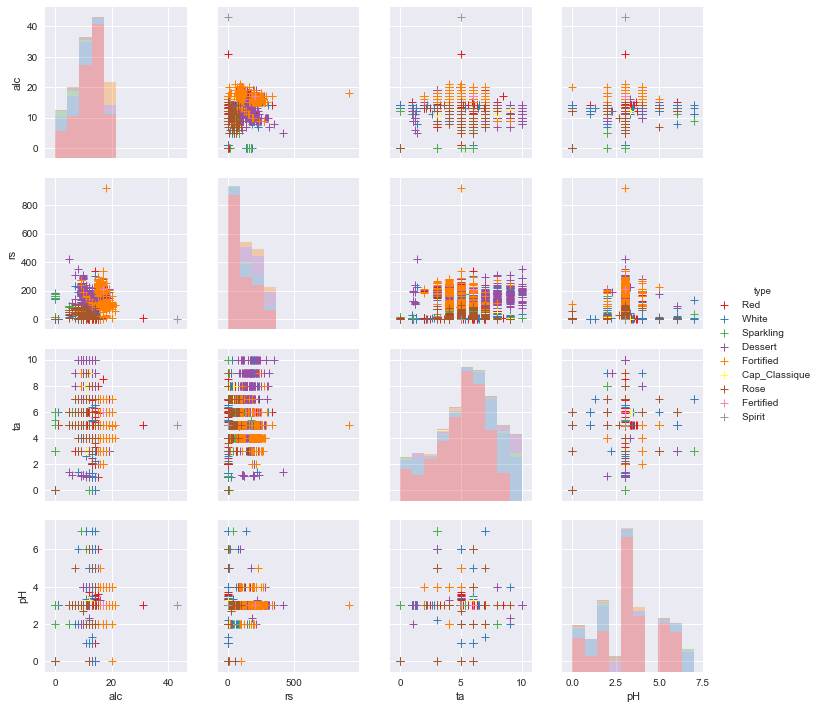

In [36]:
wineNumbers = wines[['alc','rs','ta','pH', 'type']]
print len(wineNumbers),len(wineNumbers.dropna())
g = sns.pairplot(wineNumbers.dropna(), hue='type', markers="+",
                 palette='Set1',
                 plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                 diag_kws=dict(log=True, alpha=0.3))

In [37]:
wines.to_csv(
    '~/Google Drive/Data Science/WineData/cleaned_wine_data.csv', index=0,
    encoding="utf-8")